In [1]:
%pylab inline

import pickle
import scipy.stats as stats
import scipy.optimize as opt
import pandas as pd
import deribit_api as api
import strategy as strat

tableau = pickle.load(open('tableau.colors', 'rb'))
rcParams['axes.prop_cycle'] = cycler('color',tableau)
rcParams["axes.grid"] = True
rcParams["lines.linewidth"] = 2.5
rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


In [135]:
import vol
from imp import reload
reload(vol)
from vol import *

In [4]:
keys = open('keys.txt', 'r').read().split('\n')[:-1]
client = api.RestClient(keys[0], keys[1])

In [5]:
instruments = client.getinstruments()

In [27]:
my_surface = load_surface('2017-12-30')

In [ ]:
# Pull OTM option prices 
expiry = '5JAN18'
options = [inst for inst in instruments if inst['kind'] == 'option' and expiry_codes[inst['expiration']] == expiry]
S = client.index()['btc']
OTM = [opt for opt in options if (opt['optionType'] == 'call' and opt['strike'] > S) or \
                                 (opt['optionType'] == 'put' and opt['strike'] <= S)]
for i in range(len(OTM)):
    book = client.getorderbook(OTM[i]['instrumentName'])
    bid = book['bids'][0]['price'] if len(book['bids']) > 0 else 0
    ask = book['asks'][0]['price'] if len(book['asks']) > 0 else 0
    OTM[i]['bid'] = bid
    OTM[i]['ask'] = ask
OTM = sorted(OTM, key=lambda x: x['strike'])
T = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), convert_GMT_EST(book['tstamp']*1e6))

In [ ]:
# Solve for bid and ask vols
bid_vols = np.zeros(len(OTM))
ask_vols = np.zeros(len(OTM))
for i in range(len(OTM)):
    K = OTM[i]['strike']
    r = 0.0; c = 0.0
    is_call = (OTM[i]['instrumentName'][-1] == 'C')
    bid_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['bid'], call=is_call) if OTM[i]['bid'] != 0 else 0
    ask_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['ask'], call=is_call) if OTM[i]['ask'] != 0 else 0

In [ ]:
# Plot prices
bids = np.array([S*opt['bid'] for opt in OTM])
asks = np.array([S*opt['ask'] for opt in OTM])
strikes = np.array([opt['strike'] for opt in OTM])

clean_bids = [i for i in range(len(bids)) if bids[i] != 0]
clean_asks = [i for i in range(len(asks)) if asks[i] != 0]
clean_mids = [i for i in range(len(asks)) if i in clean_bids and i in clean_asks]

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes[clean_mids], 0.5*(bids[clean_mids]+asks[clean_mids]))

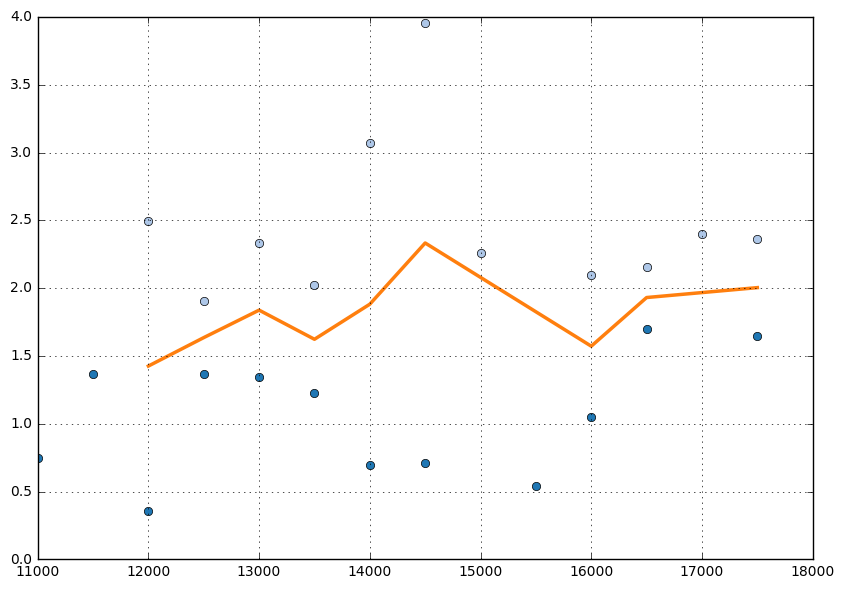

In [43]:
# Plot vols
plot(strikes[clean_bids], bid_vols[clean_bids], 'o')
plot(strikes[clean_asks], ask_vols[clean_asks], 'o')
plot(strikes[clean_mids], 0.5*(bid_vols[clean_mids]+ask_vols[clean_mids]))

In [44]:
# Fit surface
log_strikes = np.log(strikes/S)
p = opt.curve_fit(Sigma_explicit, log_strikes[clean_mids], 0.5*(bid_vols[clean_mids]+ask_vols[clean_mids]))[0]
p

array([ 1.74804222, -2.588965  , -7.5760415 ])

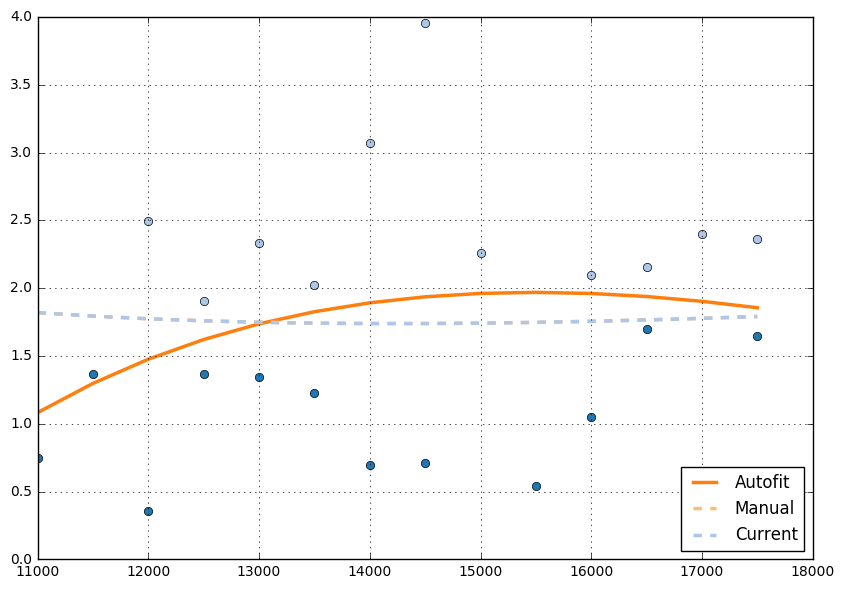

In [52]:
# Plot surface, show tweaks
pATM_shift  = 0.0
pSKEW_shift = 2.8
pVoV_shift  = 8.8

x = strikes

plot(x[clean_bids], bid_vols[clean_bids], 'o')
plot(x[clean_asks], ask_vols[clean_asks], 'o')

# Autofit
plot(x, Sigma_explicit(log_strikes,p[0],p[1],p[2]), label='Autofit')

# Modified autofit
plot(x, Sigma_explicit(log_strikes,p[0]+pATM_shift,p[1]+pSKEW_shift,p[2]+pVoV_shift), '--', label='Manual')

# Existing surface
plot(x, Sigma(log_strikes,my_surface[expiry_codes[OTM[0]['expiration']]]), '--', color=tableau[1], label='Current')

legend(loc='lower right')

In [51]:
# Save my surface
my_surface_slice = [p[0]+pATM_shift, p[1]+pSKEW_shift, p[2]+pVoV_shift]
my_surface[expiry] = my_surface_slice
save_surface(my_surface)
my_surface

{'26JAN18': [1.4608798893445119, 0.37359169696005462, 0.87785560546701225],
 '30MAR18': [1.4265465639085282, -0.024911965929328494, 0.13669175170832498],
 '5JAN18': [1.7480422181392747, 0.21103500082476234, 1.2239584958441556]}

In [54]:
def plot_surface(surface,expiry,bench):
    strikes = np.arange(40)*500+4000
    log_strikes = np.log(strikes/bench)
    sigma = Sigma(log_strikes, surface[expiry])
    plot(strikes,sigma,label=expiry)
    legend(loc='upper right')

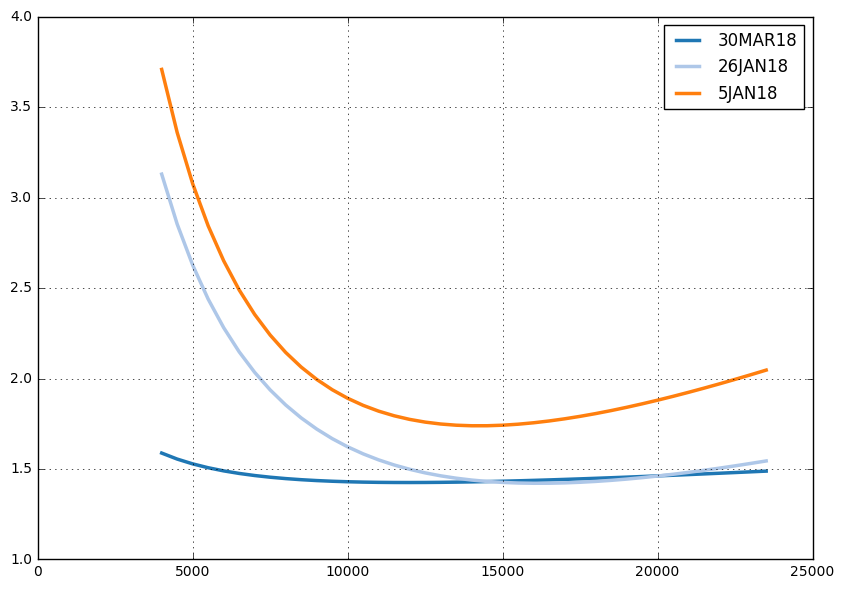

In [55]:
plot_surface(my_surface,'30MAR18',S)
plot_surface(my_surface,'26JAN18',S)
plot_surface(my_surface,'5JAN18',S)

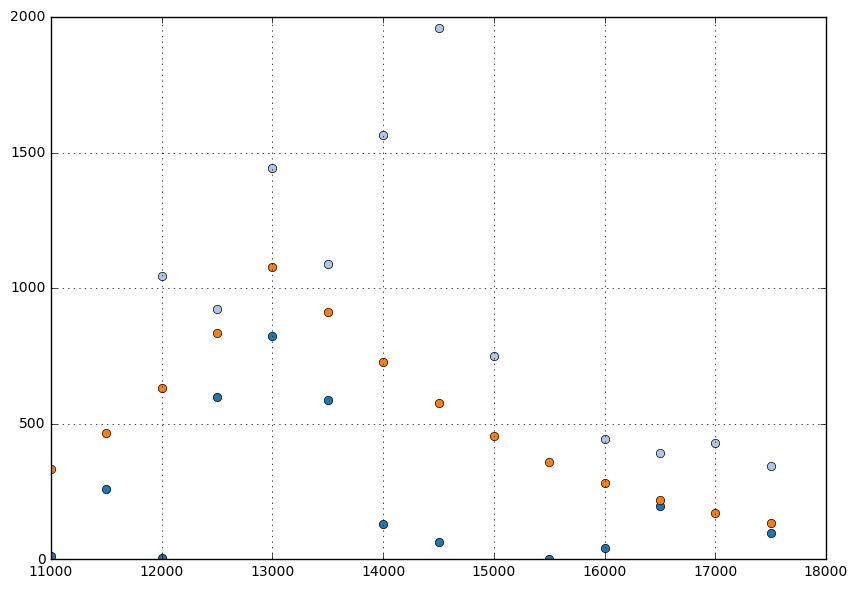

In [56]:
my_prices = np.zeros(len(strikes))
for i in range(len(strikes)):
    sigma = Sigma(np.log(strikes[i]/S), my_surface_slice)
    if strikes[i] <= S:
        my_prices[i] = BSput(S, strikes[i], T, sigma, 0.0, 0.0)
    else:
        my_prices[i] = BScall(S, strikes[i], T, sigma, 0.0, 0.0)

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes, my_prices, 'o')

In [446]:
t = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), now_EST())
index  = client.index()['btc']
strike = 17000
sigma  = Sigma(np.log(strike/index), my_surface[expiry_codes[OTM[0]['expiration']]])
BScall(index, strike, t, sigma, 0.0, 0.0)

793.41733367507868

In [126]:
S = client.index()['btc']
S

12547.57

In [98]:
options = {'BTC-30MAR18-20000-C': -1.00,
           'BTC-30MAR18-17000-C':  1.00,
           'BTC-30MAR18-35000-C': -1.00,
           'BTC-30MAR18-7000-P':   1.50,
           'BTC-30MAR18-9500-P':  -0.70,
           'BTC-5JAN18-17000-C':  -1.00,
           'BTC-5JAN18-16500-C':  -1.00}
portfolio = sorted([opt for opt in instruments if opt['instrumentName'] in options.keys()], 
                   key=lambda opt: opt['instrumentName'])

In [145]:
quantities = np.array([options[opt['instrumentName']] for opt in portfolio])
overrides = {'spot': S, 'vol_shift': 0.0, 'time_shift': -0/365}
values = np.array([PV(opt, my_surface, overrides) for opt in portfolio])
deltas = np.array([delta(opt, my_surface, overrides) for opt in portfolio])
gammas = np.array([gamma(opt, my_surface, overrides) for opt in portfolio])
vegas = np.array([vega(opt, my_surface, overrides) for opt in portfolio])
thetas = np.array([theta(opt, my_surface, overrides) for opt in portfolio])

In [146]:
df = pd.DataFrame(columns=['Px','Q','PV','Delta','Gamma','Vega','Theta'])
for idx in range(len(portfolio)):
    instrument = portfolio[idx]
    row = pd.Series()
    row['Expiry'] = expiry_codes[instrument['expiration']]
    row['PutCall'] = 'call' if instrument['instrumentName'][-1] == 'C' else 'put'
    row['Strike'] = instrument['strike']
    row['Px'] = round(values[idx],2)
    row['Q']  = quantities[idx]
    row['PV']    = values[idx]*row['Q']
    row['Delta'] = deltas[idx]*row['Q']
    row['Gamma'] = gammas[idx]*row['Q']
    row['Vega']  = vegas[idx]*row['Q']
    row['Theta'] = thetas[idx]*row['Q']
    row.name = instrument['instrumentName']
    df = df.append(row)
total = df.sum()
total.name = 'total'
total['Expiry'] = ''
total['PutCall'] = ''
total['Strike'] = ''
total['Px'] = S
df = df.append(total)[['Expiry','Strike','PutCall','PV','Q','Delta','Gamma','Vega','Theta','Px']]

In [147]:
def color_negpos(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color
df.style.\
    applymap(color_negpos,subset=['PV','Q','Delta','Gamma','Vega','Theta']).\
    format({'PV': '{:>.2f}', 'Delta': '{:>.2f}', 'Gamma': '{:>.2f}', 'Vega': '{:>.2f}', 'Theta': '{:>.2f}',
                 'Q': '{:>.1f}', 'Px': '{:>,.2f}'})

,Expiry,Strike,PutCall,PV,Q,Delta,Gamma,Vega,Theta,Px
BTC-30MAR18-17000-C,30MAR18,17000,call,2251.04,1.0,56.74,1.30,49.41,-20.06,"2,251.04"
BTC-30MAR18-20000-C,30MAR18,20000,call,-1746.63,-1.0,-45.32,-1.12,-47.63,19.61,"1,746.63"
BTC-30MAR18-35000-C,30MAR18,35000,call,-714.74,-1.0,-17.92,-0.49,-32.89,14.67,714.74
BTC-30MAR18-7000-P,30MAR18,7000,put,1155.03,1.5,-20.26,0.32,37.48,-15.32,770.02
BTC-30MAR18-9500-P,30MAR18,9500,put,-1221.68,-0.7,19.31,-0.21,-26.23,10.53,"1,745.25"
BTC-5JAN18-16500-C,5JAN18,16500,call,-148.36,-1.0,-13.88,-1.23,-6.12,49.49,148.36
BTC-5JAN18-17000-C,5JAN18,17000,call,-115.42,-1.0,-10.92,-1.00,-5.24,41.96,115.42
total,,,,-540.76,-2.2,-32.24,-2.44,-31.21,100.87,"12,547.57"


In [148]:
spots = (np.arange(51)-25)*250+S
t = time_to_expiry(pd.to_datetime('2018-01-04').tz_localize('EST'), now_EST())
values = [(quantities*np.array([PV(opt, my_surface, overrides={'spot': s, 'time_shift': -1/365}) 
          for opt in portfolio])).sum() for s in spots]

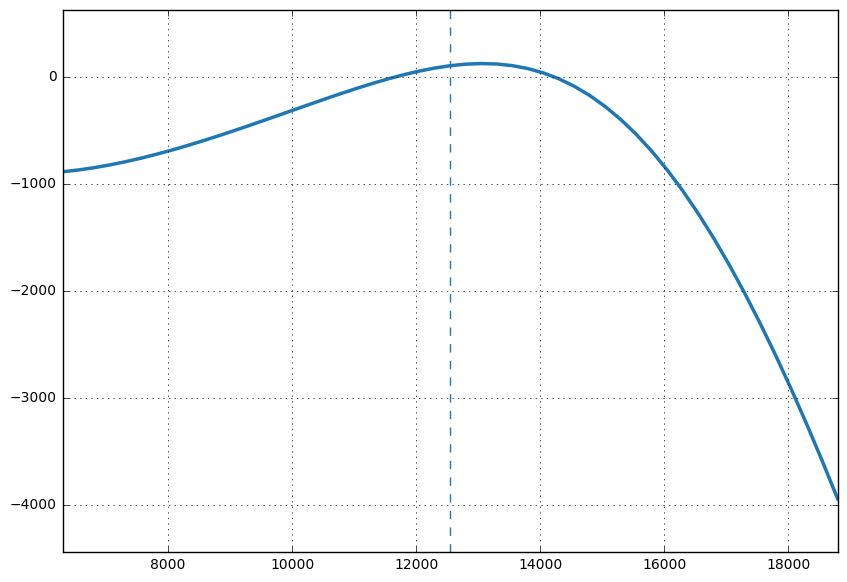

In [149]:
hedge = 0.28
pnl = values-df.loc['total'].PV+hedge*(spots-S)
plot([S,S], [np.min(pnl)-500, np.max(pnl)+500], '--', lw=1)
plot(spots, pnl, color=tableau[0])
ylim(np.min(pnl)-500,np.max(pnl)+500)
xlim(spots[0],spots[-1]);

In [97]:
name = 'BTC-5JAN18-16500-C'; Q = 1.0
option = [inst for inst in instruments if inst['instrumentName'] == name][0]
overrides = {'spot': client.index()['btc'], 'vol_shift': 0.00}
series = pd.Series()
series['Px'] = PV(option, my_surface, overrides)
series['Delta'] = delta(option, my_surface, overrides)
series['Gamma'] = gamma(option, my_surface, overrides)
series['Vega'] = vega(option, my_surface, overrides)
series['Theta'] = theta(option, my_surface, overrides)
series['Mid Vol'] = Sigma(np.log(option['strike']/S), my_surface[expiry_codes[option['expiration']]])
series['Vol'] = series['Mid Vol'] + overrides['vol_shift']
series['Spot'] = overrides['spot']
series.name = name
o = pd.DataFrame()
o = Q*o.append(series)[['Px', 'Spot', 'Vol', 'Mid Vol', 'Delta', 'Gamma', 'Vega', 'Theta']]
o.style.\
    applymap(color_negpos,subset=['PV','Q','Delta','Gamma','Vega','Theta']).\
    format({'Delta': '{:>.2f}', 'Gamma': '{:>.2f}', 'Vega': '{:>.2f}', 'Theta': '{:>.2f}',
            'Mid Vol': '{:>.2%}', 'Vol': '{:>.2%}', 'Spot': '{:>,.2f}'})

,Px,Spot,Vol,Mid Vol,Delta,Gamma,Vega,Theta
BTC-5JAN18-16500-C,193.651,"12,888.12",176.82%,176.82%,17.72,1.51,7.24,-58.49
